In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc

In [3]:
df = pd.read_csv('/home/hbs/Documents/Meenakshi/Stock_Prediction/codes/stock_data.csv')
df.columns

Index(['Date', 'Symbol', 'Close', 'Open', 'Volume', 'Low', 'High', 'id',
       'StockSectorId', 'Name', 'Sector', 'Industry'],
      dtype='object')

In [4]:
# Calculate daily returns
df['Return'] = df.groupby('Symbol')['Close'].pct_change()

In [5]:
# Volatility (rolling standard deviation of returns)
df['Volatility'] = df.groupby('Symbol')['Return'].rolling(window=20).std().reset_index(0, drop=True)

# Relative Strength Index (RSI)
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = df.groupby('Symbol').apply(calculate_rsi).reset_index(0, drop=True)

# Moving Averages (SMA_20 and SMA_50)
df['SMA_20'] = df.groupby('Symbol')['Close'].rolling(window=20).mean().reset_index(0, drop=True)
df['SMA_50'] = df.groupby('Symbol')['Close'].rolling(window=50).mean().reset_index(0, drop=True)

/tmp/ipykernel_7488/1527615380.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['RSI'] = df.groupby('Symbol').apply(calculate_rsi).reset_index(0, drop=True)


In [20]:
output_file = "/home/hbs/Downloads/df.csv"
df.to_csv(output_file, index=False)

In [6]:
df.dropna(inplace=True)

In [7]:
# Pivot the data to have returns for each stock
returns_df = df.pivot(index='Date', columns='Symbol', values='Return')
returns_df.fillna(0, inplace=True)  # Fill missing values with 0

In [19]:
df.head

<bound method NDFrame.head of               Date     Symbol    Close     Open     Volume     Low     High  \
49      2019-12-05     360ONE   312.10   319.05     8784.0  309.00   319.05   
50      2019-12-06     360ONE   305.80   311.10    14508.0  302.50   322.50   
51      2019-12-09     360ONE   295.90   312.50    15124.0  293.05   312.50   
52      2019-12-10     360ONE   281.05   303.25    19776.0  280.00   303.25   
53      2019-12-11     360ONE   278.35   283.80    14180.0  276.30   291.20   
...            ...        ...      ...      ...        ...     ...      ...   
642247  2025-02-04  ZYDUSLIFE   971.35   963.05   449026.0  960.20   975.00   
642248  2025-02-05  ZYDUSLIFE   980.00   977.00  3238404.0  945.00   986.75   
642249  2025-02-06  ZYDUSLIFE  1007.75   984.00  5290644.0  976.00  1026.55   
642250  2025-02-07  ZYDUSLIFE   994.15  1008.20  1323744.0  989.05  1012.75   
642251  2025-02-10  ZYDUSLIFE   965.45   996.00   578417.0  958.60   998.40   

         id  StockSec

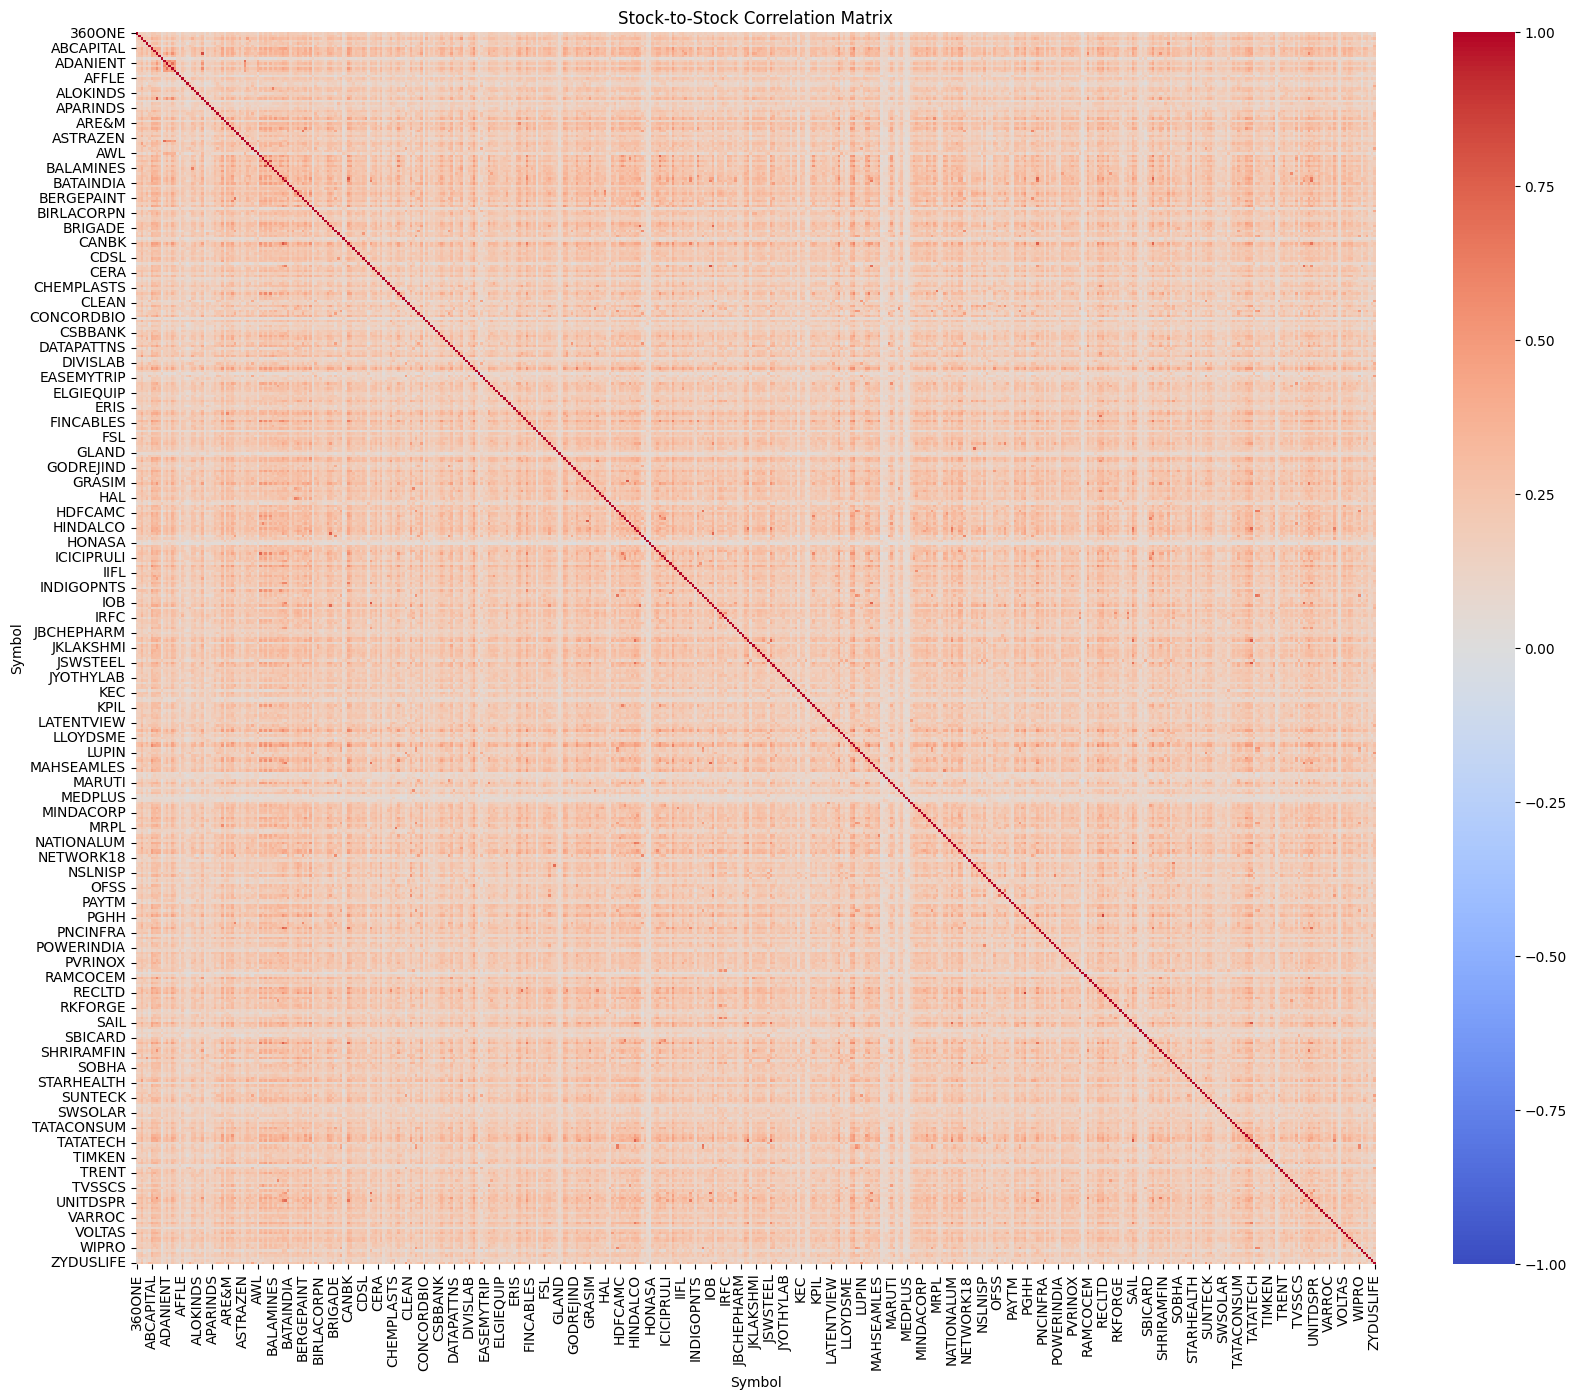

In [8]:
# Compute the correlation matrix
corr_matrix = returns_df.corr()

# Visualize the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Stock-to-Stock Correlation Matrix')
plt.show()

In [9]:
# Define thresholds
high_corr_threshold = 0.7
inverse_corr_threshold = -0.5

# Extract highly correlated pairs
high_corr_pairs = []
inverse_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i, j]
        if corr_value > high_corr_threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_value))
        elif corr_value < inverse_corr_threshold:
            inverse_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_value))

# Print results
print("Highly Correlated Pairs:")
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")

print("\nInversely Correlated Pairs:")
for pair in inverse_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")

Highly Correlated Pairs:
ACC and AMBUJACEM: 0.83
AXISBANK and ICICIBANK: 0.74
BAJAJFINSV and BAJFINANCE: 0.82
BANKBARODA and CANBK: 0.78
BANKBARODA and PNB: 0.74
BANKBARODA and SBIN: 0.74
BPCL and HINDPETRO: 0.76
BPCL and IOC: 0.72
CANBK and PNB: 0.75
CANBK and SBIN: 0.73
CENTRALBK and IOB: 0.79
GRAPHITE and HEG: 0.78
HINDALCO and TATASTEEL: 0.73
HINDPETRO and IOC: 0.72
IOB and MAHABANK: 0.73
JINDALSTEL and JSWSTEEL: 0.74
JINDALSTEL and SAIL: 0.70
JINDALSTEL and TATASTEEL: 0.77
JSWSTEEL and TATASTEEL: 0.78
NATIONALUM and SAIL: 0.72
PFC and RECLTD: 0.86
PNB and UNIONBANK: 0.70
SAIL and TATASTEEL: 0.78

Inversely Correlated Pairs:


In [10]:
# Aggregate returns by sector
sector_returns = df.groupby(['Date', 'Sector'])['Return'].mean().unstack()
sector_returns.fillna(0, inplace=True)  # Fill missing values with 0

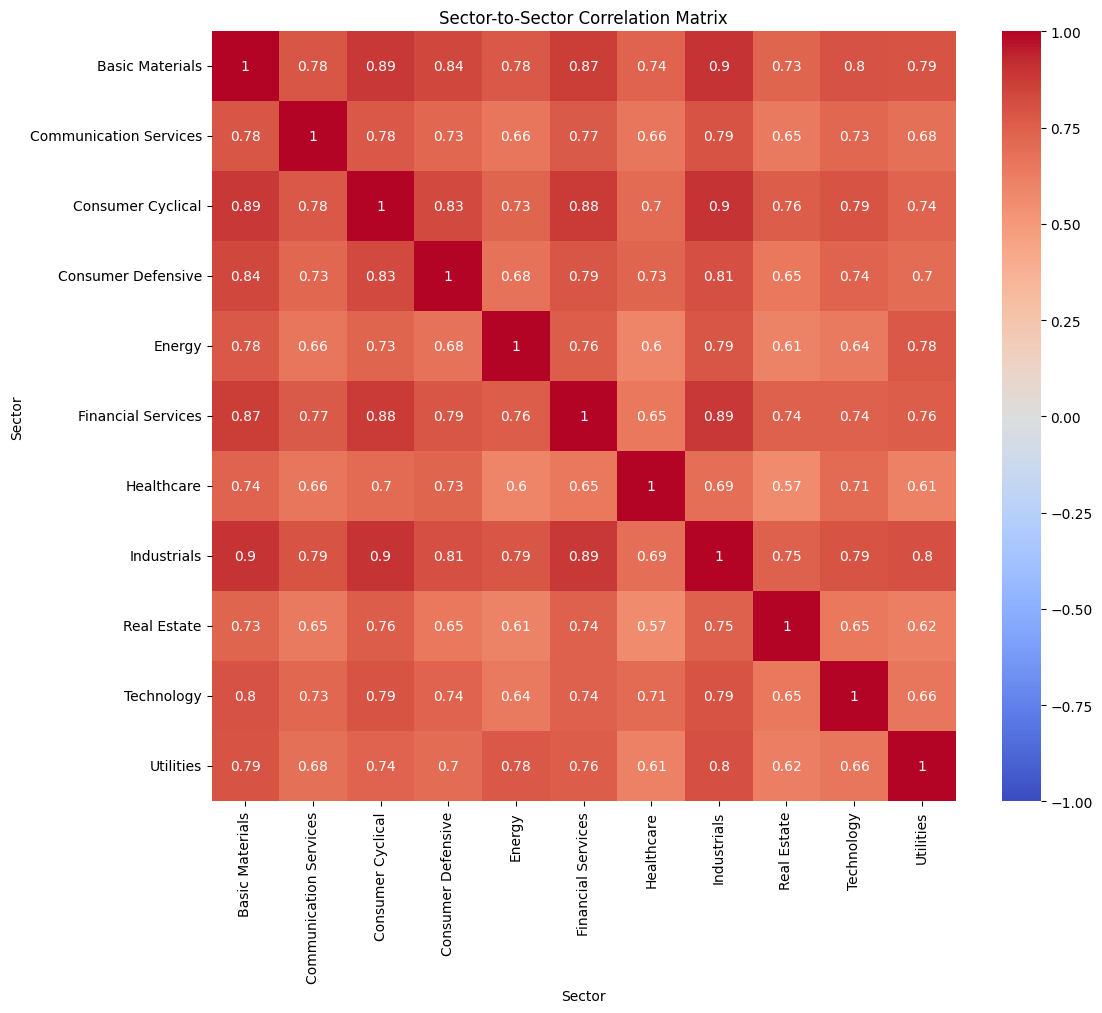

In [11]:
# Compute the sector correlation matrix
sector_corr_matrix = sector_returns.corr()

# Visualize the sector correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(sector_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Sector-to-Sector Correlation Matrix')
plt.show()

In [12]:
# Label stocks based on future performance
def create_labels(data, lookahead_days=10, threshold=0.05):
    data['Future_Return'] = data.groupby('Symbol')['Close'].pct_change(lookahead_days).shift(-lookahead_days)
    data['Label'] = (data['Future_Return'] > threshold).astype(int)  # 1 for good, 0 for bad
    return data

df = create_labels(df)
df.dropna(inplace=True)  # Drop rows with NaN values caused by shifting

In [13]:
features = ['Return', 'Volatility', 'RSI', 'SMA_20', 'SMA_50']
X = df[features]
y = df['Label']

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.98      0.86     90790
           1       0.66      0.12      0.21     31833

    accuracy                           0.76    122623
   macro avg       0.71      0.55      0.53    122623
weighted avg       0.73      0.76      0.69    122623



In [17]:
import joblib

# Save the trained model
joblib.dump(model, 'stock_prediction_model.pkl')

# Save the scaler (if used)
#joblib.dump(scaler, 'scaler.pkl')

['stock_prediction_model.pkl']